# Deep Recurrent Q-Network

이 노트북은 부분 관찰가능 마르코프 결정 프로세스를 풀 수 있는 Deep Recurrent Q-Network의 구현 예제를 제공한다.

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
%matplotlib inline

# helper 에는 타겟 신경망 그라디언트 업데이트 등이 들어있다.
from helper import *

# 게임 환경 불러오기

In [2]:
from gridworld import gameEnv

격자 세계의 크기는 조절 가능하다. 크기를 더 작게 만들면 DRQN 에이전트에게 쉬운 작업을 제공하고, 반대로 더 큰 세상은 도전과제가 된다.

시야의 제한을 True로 설정하면, 부분 관찰가능 MDP가 된다. False 로 설정하면, 에이전트에게 전체 환경을 제공하는 완전한 MDP가 된다.

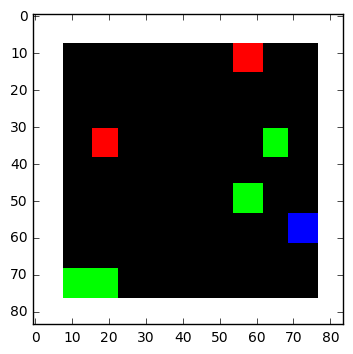

In [3]:
# MDP
env = gameEnv(partial=False,size=9)

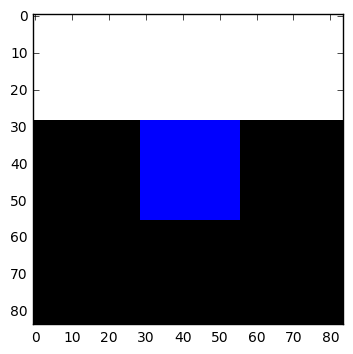

In [4]:
# POMDP
env = gameEnv(partial=True,size=9)

위에는 우리 게임에서 시작 환경의 예이다. 에이전트는 파란 사각형을 조정하고, 위, 아래, 왼쪽, 오른쪽으로 이동가능하다. 목표는 초록 사각형(+1 보상)으로 이동하고 빨간 사각형(-1 보상)을 피하는 것이다. 에이전트가 초록이나 빨간 사각형으로 이동하면, 새로운 장소에 초기화된다.

# 신경망 구현하기

In [5]:
class Qnetwork():
    def __init__(self,h_size,rnn_cell,myScope):
        # 신경망은 게임으로부터 벡터화된 배열로 프레임을 받아서,
        # 이것을 리사이즈 하고, 4개의 콘볼루션을 통해 처리한다.
        
        # 입력값을 받는 부분 21168 차원은 84*84*3 의 차원이다.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        # conv2d 처리를 위해 84x84x3 으로 다시 리사이즈
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        
        # 첫번째 콘볼루션은 8x8 커널을 4 스트라이드로 32개의 activation map을 만든다
        # 출력 크기는 (image 크기 - 필터 크기) / 스트라이드 + 1 이다.
        # zero padding이 없는 VALID 옵션이기 때문에
        # (84-8)/4 + 1
        # 20x20x32 의 activation volumn이 나온다
        self.conv1 = slim.convolution2d( \
            inputs=self.imageIn,num_outputs=32,\
            kernel_size=[8,8],stride=[4,4],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv1')
        
        # 두번째 콘볼루션은 4x4 커널을 2 스트라이드로 64개의 activation map을 만든다.
        # 출력 크기는 9x9x64
        self.conv2 = slim.convolution2d( \
            inputs=self.conv1,num_outputs=64,\
            kernel_size=[4,4],stride=[2,2],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv2')
        
        # 세번째 콘볼루션은 3x3 커널을 1 스트라이드로 64개의 activation map을 만든다.
        # 출력 크기는 7x7x64
        self.conv3 = slim.convolution2d( \
            inputs=self.conv2,num_outputs=64,\
            kernel_size=[3,3],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv3')
        
        # 네번째 콘볼루션은 7x7 커널을 1 스트라이드 512개의 activation map을 만든다.
        # 출력 크기는 1x1x512
        self.conv4 = slim.convolution2d( \
            inputs=self.conv3,num_outputs=512,\
            kernel_size=[7,7],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv4')
        
        
        # 몇개의 걸음 기록을 사용할지 받아들이는 부분
        self.trainLength = tf.placeholder(dtype=tf.int32)
        
        # 마지막 콘볼루션 레이어로부터의 출력을 받아, 순환 레이어로 보낸다.
        # 이 입력은 rnn 처리과정을 위해 [배치 x 걸음 기록(trace) x rnn hidden node unit 수] 로 크기 조정 되어야만 한다.
        # 그리고 rnn의 윗부분을 통과해 [batch x units]을 반환한다
        
        # 배치 사이즈를 받는 부분
        self.batch_size = tf.placeholder(dtype=tf.int32)
        # 콘볼루션의 마지막 부분 1x1x512 를 512 로 바꾸고, 이를 batch x trace x hidden node 로 바꿈
        self.convFlat = tf.reshape(slim.flatten(self.conv4),[self.batch_size,self.trainLength,h_size])
        # rnn hidden node의 초기 상태를 0으로 초기화
        self.state_in = cell.zero_state(self.batch_size, tf.float32)
        # dynamic_rnn 을 이용해 rnn output과 다음 상태를 반환함
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                inputs=self.convFlat,cell=rnn_cell,dtype=tf.float32,initial_state=self.state_in,scope=myScope+'_rnn')
        # 벡터화해줌
        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        
        # 순환 레이어의 결과를 절반으로 나눠서 가치와 이득 흐름으로 넣어줌
        self.streamA,self.streamV = tf.split(1,2,self.rnn)
        self.AW = tf.Variable(tf.random_normal([int(h_size/2),4]))
        self.VW = tf.Variable(tf.random_normal([int(h_size/2),1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        # 가치 함수 값에 이득에서 이득의 평균을 빼준 값들을 더해준다.
        self.Qout = self.Value + tf.sub(self.Advantage,tf.reduce_mean(self.Advantage,reduction_indices=1,keep_dims=True))
        # 이것으로 행동을 고른다.
        self.predict = tf.argmax(self.Qout,1)
        
        # 타겟과 예측 Q value 사이의 차이의 제곱합이 손실이다.
        # 타겟Q를 받는 부분
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        # 행동을 받는 부분
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        # 행동을 one_hot 인코딩 하는 부분
        self.actions_onehot = tf.one_hot(self.actions,4,dtype=tf.float32)
        
        # 각 네트워크의 행동의 Q 값을 골라내는 것
        # action 번째를 뽑고 싶지만 tensor는 인덱스로 쓸 수 없어서 이렇게 하는듯(내 생각)
        self.Q = tf.reduce_sum(tf.mul(self.Qout, self.actions_onehot), reduction_indices=1)
        
        # 각각의 차이
        self.td_error = tf.square(self.targetQ - self.Q)
        
        #신경망을 통해 정확한 그라디언트만 보내기 위해, Lample & Chatlot 2016 에서 각 기록에 대한 손실의 첫 절반을 마스크 할 것이다.
        self.maskA = tf.zeros([self.batch_size,4]) # 4는 trace 의 수
        self.maskB = tf.ones([self.batch_size,4])
        self.mask = tf.concat(1,[self.maskA,self.maskB])
        self.mask = tf.reshape(self.mask,[-1])
        
        # 뒤에 절반만 가지고 손실을 계산한다
        self.loss = tf.reduce_mean(self.td_error * self.mask)
        
        # 최적화 방법 adam
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        # 업데이트 함수
        self.updateModel = self.trainer.minimize(self.loss)

# 경험 재생 (Experience Replay)

이들 클래스는 경험들을 저장하고 신경망을 학습하기 위해 무작위로 샘플링 한다. Episode buffer는 각 개별 에피소드에 대한 경험을 저장한다. Experience buffer 는 경험의 전체 에피소드를 저장하고, sample() 함수를 통해 신경망에서 필요한 학습 배치를 제공한다.

In [6]:
class experience_buffer():
    def __init__(self, buffer_size = 1000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    # 더할 때 버퍼사이즈를 넘으면, 앞에서부터 지우고 다시 넣는다.
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
            
    def sample(self,batch_size,trace_length):
        sampled_episodes = random.sample(self.buffer,batch_size)
        sampledTraces = []
        # 이전과 다른 부분, 샘플로 뽑힌 에피소드에서 지정된 크기만큼의 걸음(프레임)을 붙여서 가져온다.
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-trace_length)
            sampledTraces.append(episode[point:point+trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size*trace_length,5])

# 신경망 학습하기

In [7]:
# 학습 파라미터 설정하기
batch_size = 4 # 각 학습 단계에서 경험 기록을 몇개나 사용할지
trace_length = 8 # 학습할 때 각 경험 기록을 얼마나 길게 사용할지
update_freq = 5 # 학습 단계를 얼마나 자주 수행할지
y = .99 # 타겟 Q value 에 대한 할인 인자
startE = 1 # 무작위 행위의 시작 확률
endE = 0.1 # 무작위 행위의 최종 확률
anneling_steps = 10000 # startE부터 endE까지 몇단계에 걸쳐서 줄일 것인가.
num_episodes = 10000 # 몇개의 에피소드를 할 것인가.
pre_train_steps = 10000 # 학습 시작 전에 몇번의 무작위 행위를 할 것인가.
load_model = False # 저장된 모델을 불러올 것인가?
path = "./drqn" # 모델을 저장할 위치
h_size = 512 # 이득 함수와 가치 함수로 나뉘기 전에 최종 콘볼루션의 크기
max_epLength = 50 # 에피소드의 최대 길이 (50 걸음)
time_per_step = 1 # git 생성에 사용될 각 걸음의 크기 
summaryLength = 100 # 분석을 위해 주기적으로 저장하기 위한 에피소드의 수

In [8]:
# 그래프를 초기화한다
tf.reset_default_graph()

# 주요 신경망과 타겟 q-network를 위한 rnn 셀들을 정의한다.
cell = tf.nn.rnn_cell.LSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.nn.rnn_cell.LSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

# 변수들을 초기화한다
init = tf.global_variables_initializer()

# gpu 에러를 방지
config = tf.ConfigProto(
        device_count={'GPU': 0}  # uncomment this line to force CPU
    )

# saver를 만든다
saver = tf.train.Saver(max_to_keep=5)

# 학습가능한 변수를 꺼낸다
trainables = tf.trainable_variables()

# 타겟 신경망을 업데이트하기 위한 값을 만든다
targetOps = updateTargetGraph(trainables)

# 경험을 저장할 장소
myBuffer = experience_buffer()

# 무작위 행위 확률을 설정한다
e = startE
# 점점 줄여나간다.
stepDrop = (startE - endE)/anneling_steps

# 에피소드별 총 보상과 걸음을 저장할 리스트를 만든다
jList = []
rList = []
total_steps = 0

# 모델을 세이브할 장소를 만든다.
if not os.path.exists(path):
    os.makedirs(path)

# 컨트롤 센터를 위한 로그파일을 만드는 것인데, 나는 컨트롤 센터가 없으니 안 만든다.
##Write the first line of the master log-file for the Control Center
# with open('./Center/log.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(['Episode','Length','Reward','IMG','LOG','SAL'])    
  
# 텐서플로 세션을 연다
with tf.Session(config=config) as sess:
    # 모델을 불러올지 체크
    if load_model == True:
        print ('Loading Model...')
        # 모델을 불러온다
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    # 변수를 초기화한다.
    sess.run(init)
    
    # 주요 신경망과 동일하게 타겟 신경망을 설정한다
    updateTarget(targetOps,sess)
    
    # 텐서보드를 위해 요약 변수들을 저장
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./train',
                                    sess.graph)
    
    # 에피소드 시작
    for i in range(num_episodes):
        # 에피소드별 경험 버퍼를 초기화한다
        episodeBuffer = []
        # 환경과 처음 상태을 초기화한다
        sP = env.reset()
        s = processState(sP)
        # 종료 여부
        d = False
        # 보상
        rAll = 0
        # 걸음
        j = 0
        # 순환 레이어의 은닉 상태를 초기화한다.
        state = (np.zeros([1,h_size]),np.zeros([1,h_size]))
        # Q-Network
        # 만약 50 걸음보다 더 간다면 종료한다.
        #The Q-Network
        while j < max_epLength: 
            j+=1
            # Q-network 로부터 행동을 greedy 하게 선택하거나 e의 확률로 무작위 행동을 한다
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                state1 = sess.run(mainQN.rnn_state,\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                # 신경망을 통해 Q 값을 가져오는 부분
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = a[0]
            # 주어진 행동을 실행하고 다음 상태, 보상, 종료 여부를 가져옴
            s1P,r,d = env.step(a)
            # 상태를 다시 21168 차원으로 리사이즈
            s1 = processState(s1P)
            # 걸음수를 늘림
            total_steps += 1
            # 버퍼에 현재 상태, 행동, 보상, 다음 상태, 종료 여부를 저장한다
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            
            # 무작위 행동의 수를 넘으면 시작
            if total_steps > pre_train_steps:
                # 무작위 확률 값을 줄인다
                if e > endE:
                    e -= stepDrop
                
                # 총 걸음이 업데이트 수로 나누어 떨어지면 시작
                if total_steps % (update_freq*1000) == 0:
                    print ("Target network updated.")
                    updateTarget(targetOps,sess)

                if total_steps % (update_freq) == 0:
                    # 순환 레이어의 은닉층을 초기화한다.
                    state_train = (np.zeros([batch_size,h_size]),np.zeros([batch_size,h_size])) 
                    
                    # 경험으로부터 랜덤한 배치를 뽑는다
                    trainBatch = myBuffer.sample(batch_size,trace_length)
                    # 아래는 target Q-value를 업데이트하는 Double-DQN을 수행한다
                    # 주요 신경망에서 행동을 고른다.
                    Q1 = sess.run(mainQN.predict,feed_dict={\
                        mainQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
                    # 타겟 신경망에서 Q 값들을 얻는다.
                    Q2 = sess.run(targetQN.Qout,feed_dict={\
                        targetQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
                    # 종료 여부에 따라 가짜 라벨을 만들어준다
                    end_multiplier = -(trainBatch[:,4] - 1)
                    # 타겟 신경망의 Q 값들 중에 주요 신경망에서 고른 행동 번째의 Q 값들을 가져온다.(이부분이 doubleQ)
                    doubleQ = Q2[range(batch_size*trace_length),Q1]
                    # 보상에 대한 더블 Q 값을 더해준다. y는 할인 인자
                    # targetQ 는 즉각적인 보상 + 다음 상태의 최대 보상(doubleQ)
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    # 우리의 타겟 값들과 함께 신경망을 업데이트해준다.
                    # 행동들에 대해서 targetQ 값과의 차이를 통해 손실을 구하고 업데이트
                    sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]/255.0),mainQN.targetQ:targetQ,\
                        mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                        mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            # 총 보상
            rAll += r
            # 상태를 바꾼다
            s = s1
            sP = s1P
            # 은닉 상태를 바꾼다
            state = state1
            # 종료
            if d == True:

                break

        # 경험 버퍼에 에피소드를 추가한다
        bufferArray = np.array(episodeBuffer)
        episodeBuffer = bufferArray
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)

        # 주기적으로 모델을 저장한다
        if i % 1000 == 0 and i != 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print ("Saved Model")
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print (total_steps,np.mean(rList[-summaryLength:]), e)
#             saveToCenter(i,rList,jList,np.reshape(np.array(episodeBuffer),[len(episodeBuffer),5]),\
#                 summaryLength,h_size,sess,mainQN,time_per_step)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')

Target Set Success
5000 0.57 1
10000 0.33 1
Target network updated.
Target Set Success
15000 1.2 0.5499999999998275
Target network updated.
Target Set Success
20000 2.14 0.09999999999985551
Target network updated.
Target Set Success
25000 2.02 0.09999999999985551
Target network updated.
Target Set Success
30000 2.92 0.09999999999985551
Target network updated.
Target Set Success
35000 3.37 0.09999999999985551
Target network updated.
Target Set Success
40000 3.21 0.09999999999985551
Target network updated.
Target Set Success
45000 3.54 0.09999999999985551
Target network updated.
Target Set Success
50000 3.72 0.09999999999985551
Saved Model
Target network updated.
Target Set Success
55000 3.81 0.09999999999985551
Target network updated.
Target Set Success
60000 3.12 0.09999999999985551
Target network updated.
Target Set Success
65000 3.93 0.09999999999985551
Target network updated.
Target Set Success
70000 2.33 0.09999999999985551
Target network updated.
Target Set Success
75000 3.63 0.09

# 신경망 평가하기

In [9]:
e = 0.01
num_episodes = 10000
load_model = True
path = "./drqn"
h_size = 512
max_epLength = 50 
time_per_step = 1
summaryLength = 100

In [10]:
tf.reset_default_graph()
cell = tf.nn.rnn_cell.LSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.nn.rnn_cell.LSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

config = tf.ConfigProto(
        device_count={'GPU': 0}  # uncomment this line to force CPU
    )

saver = tf.train.Saver(max_to_keep=2)

jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

##Write the first line of the master log-file for the Control Center
# with open('./Center/log.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(['Episode','Length','Reward','IMG','LOG','SAL'])    
    
    #wr = csv.writer(open('./Center/log.csv', 'a'), quoting=csv.QUOTE_ALL)
with tf.Session(config=config) as sess:
    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        sess.run(init)

        
    for i in range(num_episodes):
        episodeBuffer = []
        sP = env.reset()
        s = processState(sP)
        d = False
        rAll = 0
        j = 0
        state = (np.zeros([1,h_size]),np.zeros([1,h_size]))
        #The Q-Network
        while j < max_epLength: 
            j+=1
            
            if np.random.rand(1) < e:
                state1 = sess.run(mainQN.rnn_state,\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,\
                    mainQN.state_in:state,mainQN.batch_size:1})
                a = a[0]
            s1P,r,d = env.step(a)
            s1 = processState(s1P)
            total_steps += 1
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            rAll += r
            s = s1
            sP = s1P
            state = state1
            if d == True:

                break

        bufferArray = np.array(episodeBuffer)
        jList.append(j)
        rList.append(rAll)

        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print (total_steps,np.mean(rList[-summaryLength:]), e)
#             saveToCenter(i,rList,jList,np.reshape(np.array(episodeBuffer),[len(episodeBuffer),5]),\
#                 summaryLength,h_size,sess,mainQN,time_per_step)
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Loading Model...
5000 6.53 0.01
10000 6.41 0.01
15000 6.67 0.01
20000 7.39 0.01
25000 6.54 0.01
30000 6.83 0.01
35000 6.63 0.01
40000 6.58 0.01
45000 6.98 0.01
50000 6.87 0.01
55000 6.41 0.01
60000 6.5 0.01
65000 6.94 0.01
70000 6.54 0.01
75000 6.91 0.01
80000 6.9 0.01
85000 6.38 0.01
90000 6.57 0.01
95000 6.69 0.01
100000 6.37 0.01
105000 6.61 0.01
110000 6.7 0.01
115000 6.32 0.01
120000 6.69 0.01
125000 6.92 0.01
130000 6.55 0.01
135000 6.26 0.01
140000 6.57 0.01
145000 6.69 0.01
150000 6.53 0.01
155000 6.47 0.01
160000 6.76 0.01
165000 6.84 0.01
170000 6.73 0.01
175000 6.76 0.01
180000 6.54 0.01
185000 6.6 0.01
190000 6.89 0.01
195000 6.75 0.01
200000 6.82 0.01
205000 6.78 0.01
210000 6.47 0.01
215000 6.46 0.01
220000 6.72 0.01
225000 6.25 0.01
230000 6.75 0.01
235000 6.56 0.01
240000 6.85 0.01
245000 6.65 0.01
250000 6.9 0.01
255000 6.73 0.01
260000 6.36 0.01
265000 6.36 0.01
270000 6.43 0.01
275000 6.8 0.01
280000 6.19 0.01
285000 6.61 0.01
290000 6.68 0.01
295000 6.54 0.01
300000